In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

# Import data and delte unnecessary columns
df = pd.read_csv('name_SMILES_kd.csv', sep=',', encoding = 'ISO-8859-1')
df.drop(df.columns[[1, 2, 3, 4, 8, 9]], axis=1, inplace=True)
df.insert(3, 'LogKd', np.log10(df['Kd']))

#df['label'] = np.where(df['label'] >= cutoff, 1, 0)
df.head(5)

,Ligand,Type,SMILES,LogKd,Kd
0,Tobramycin,DNA,C1[C@@H]([C@H]([C@@H]([C@H]([C@@H]1N)O[C@@H]2[...,-0.823909,0.15000
1,Melamine,DNA,C1(=NC(=NC(=N1)N)N)N,-0.292430,0.51000
2,Ofloxacin,DNA,CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(...,-3.958607,0.00011
3,Gonyautoxin 1/4 (GTX1/4)Ê,DNA,C1[C@H](C([C@@]23N1C(=N)N([C@H]([C@@H]2NC(=N3)...,-1.752027,0.01770
4,Fluoroacetamide,DNA,C(C(=O)N)F,1.397940,25.00000


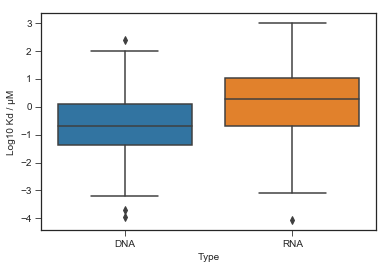

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks', {'axes.grid': False, })
%matplotlib inline

sns.boxplot(x='Type', y=df.LogKd, data=df).set(ylabel='Log10 Kd / µM');

In [3]:
import warnings; warnings.simplefilter('ignore')
import deepchem as dc

df.to_csv('data.csv', header=True)

def featurize_SMILES (dataset_file, smiles_field, featurizer_func):
    loader = dc.data.CSVLoader(tasks=[], smiles_field=smiles_field, 
                               featurizer=featurizer_func)
    dataset = loader.featurize(dataset_file)
    return pd.DataFrame(dataset.X)

df_features = featurize_SMILES('data.csv', 'SMILES', dc.feat.CircularFingerprint())
df_features.head(5)

Instructions for updating:
Use the retry module or similar alternatives.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from data.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.722 s
TIMING: dataset construction took 0.754 s
Loading dataset from disk.


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


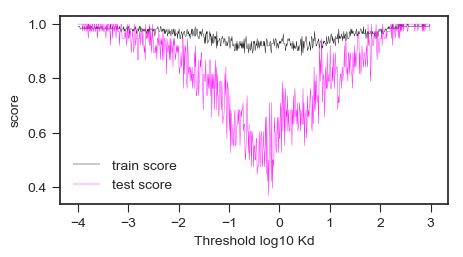

In [8]:
import warnings; warnings.simplefilter('ignore')

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


thresholds = np.arange(-4,3,0.01)
train_scores, test_scores = [], []
for threshold in thresholds:
    y = np.where(df['LogKd'] >= threshold, 1, 0)
    
    X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=.25)
    
    clf = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                        max_delta_step=1, max_depth=3, min_child_weight=1, 
                        n_estimators=100, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.figure(figsize=[5,2.5], dpi=100)
plt.plot(thresholds, train_scores, color='black', lw=0.3, label='train score')
plt.plot(thresholds, test_scores, color='magenta', lw=0.3, label='test score')

plt.legend(loc='lower left')
#plt.ylim(0.5,1.05)
plt.xlabel('Threshold log10 Kd')
plt.ylabel('score');


In [120]:
import warnings; warnings.simplefilter('ignore')

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


seed = 42
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                    random_state=seed)

classifier = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                           max_delta_step=1, max_depth=3, min_child_weight=1, 
                           n_estimators=100, n_jobs=1, random_state=42)
classifier.fit(X_train, y_train)

print(classifier)
print('')

# make predictions for test data
y_pred = classifier.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
y_pred_full = classifier.predict(X)
data = confusion_matrix(y, y_pred_full)
print('Confusion matrix')
print(data)
        

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Accuracy: 60.53%
Confusion matrix
[[ 27  16]
 [  5 102]]


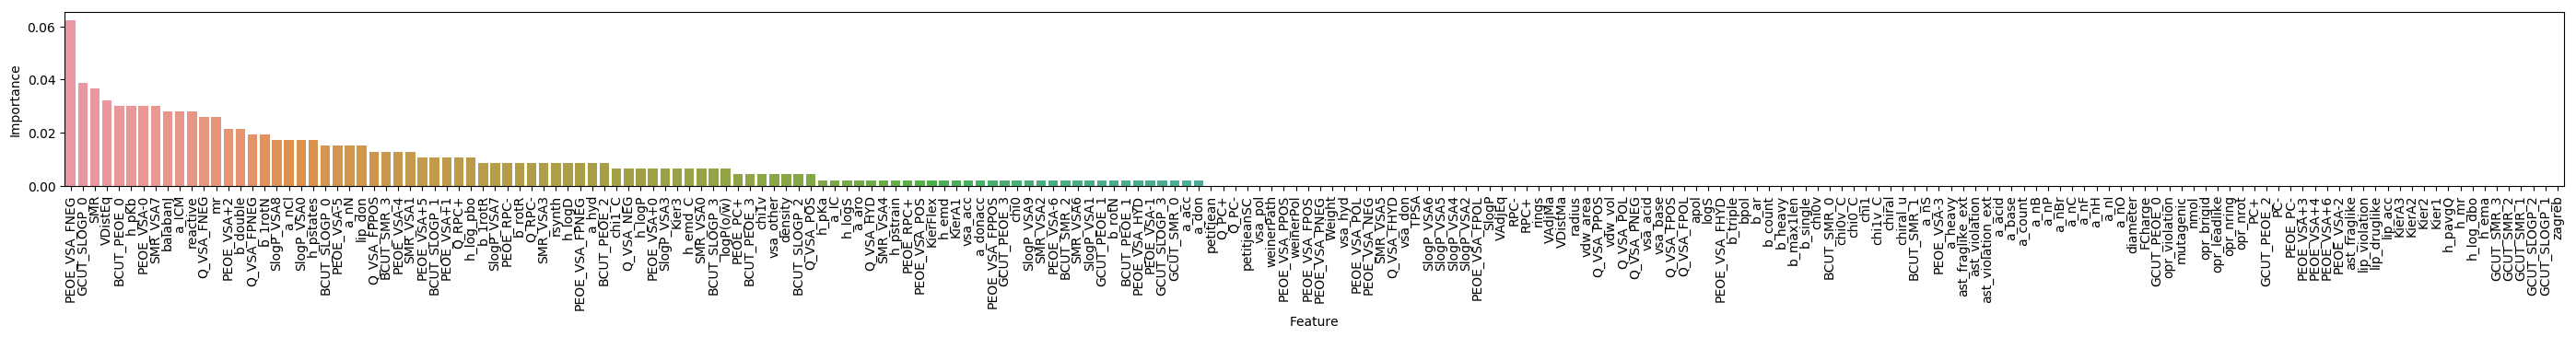

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

df_fi = pd.DataFrame(columns=['Feature','Importance'])
df_fi['Feature']    = X.columns.ravel()
df_fi['Importance'] = classifier.feature_importances_.ravel()
df_fi.sort_values('Importance', ascending=False, inplace=True)
df_fi.reset_index(inplace=True, drop=True)


plt.figure(figsize=[35,2.5], dpi=100)

#plt.xticks ([0])
ax = sns.barplot(x='Feature', y="Importance", data=df_fi)
for item in ax.get_xticklabels():
    item.set_rotation(90)

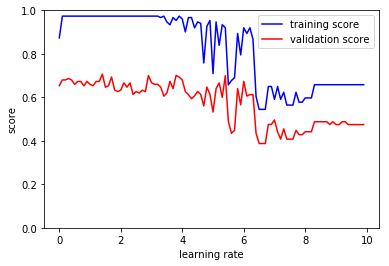

In [122]:
import numpy as np
from sklearn.model_selection import validation_curve

n_estimators = np.arange(1,200,10)
learning_rate = np.arange(0.0001, 10, 0.1)


train_score, val_score = validation_curve(classifier, X, y, 'learning_rate', learning_rate, cv=2)


# hier noch den graphischen Output einfügen
plt.plot(learning_rate, np.median(train_score, 1), color='blue', label='training score')
plt.plot(learning_rate, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0,1)
plt.xlabel('learning rate')
plt.ylabel('score');



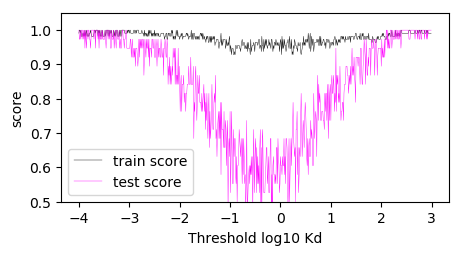

In [123]:
from sklearn.model_selection import cross_val_score



thresholds = np.arange(-4,3,0.01)
train_scores, test_scores = [], []
for threshold in thresholds:
    y = np.where(df['LogKd'] >= threshold, 1, 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
    
    clf = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                        max_delta_step=1, max_depth=3, min_child_weight=1, 
                        n_estimators=100, n_jobs=-1)
    
    #scores.append(cross_val_score(clf, X, y, cv=5, n_jobs=-1))
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.figure(figsize=[5,2.5], dpi=100)
plt.plot(thresholds, train_scores, color='black', lw=0.3, label='train score')
plt.plot(thresholds, test_scores, color='magenta', lw=0.3, label='test score')

plt.legend(loc='lower left')
#plt.ylim(0.5,1.05)
plt.xlabel('Threshold log10 Kd')
plt.ylabel('score');


In [124]:
from sklearn.metrics import accuracy_score, confusion_matrix


y = np.where(df['LogKd'] >= -1.0, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)
    
clf = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                    max_delta_step=1, max_depth=3, min_child_weight=1, 
                    n_estimators=100, n_jobs=-1)

clf.fit(X_train, y_train)

# make predictions for test data
y_pred = clf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
y_pred_full = clf.predict(X)
data = confusion_matrix(y, y_pred_full)
print('Confusion matrix')
print(data)
        
    

Accuracy: 63.16%
Confusion matrix
[[ 30  13]
 [  7 100]]


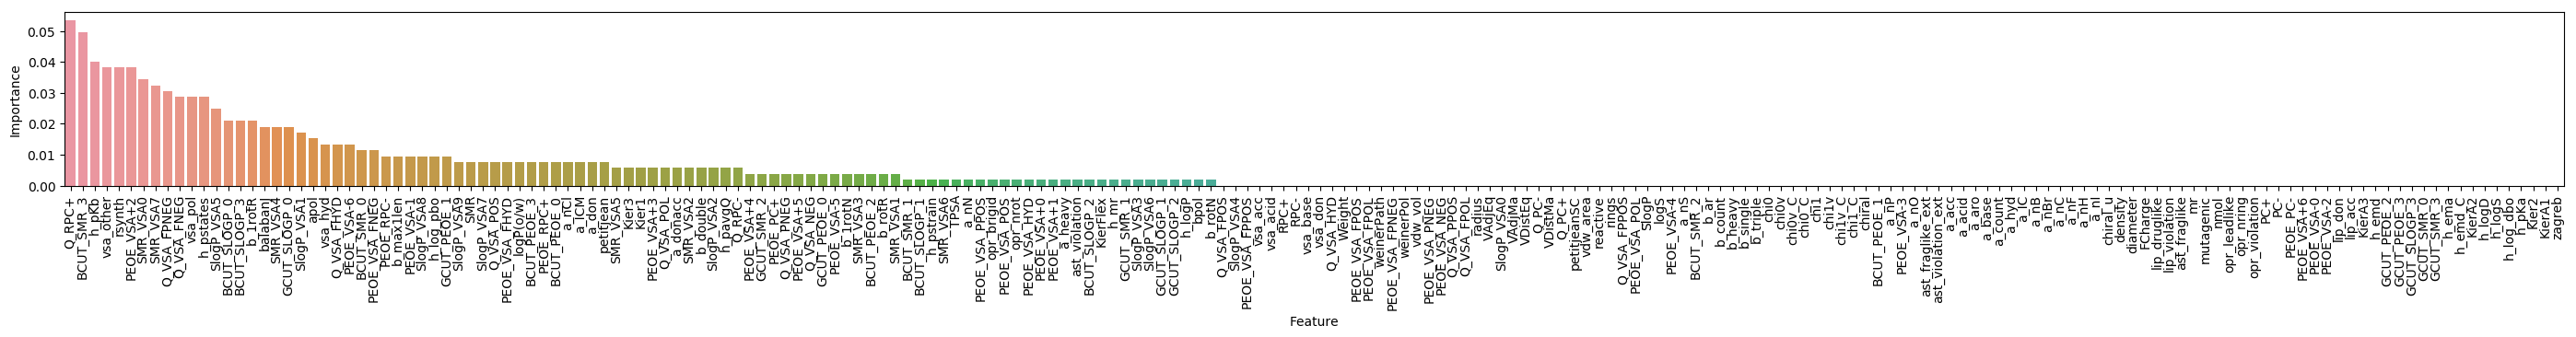

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

df_fi = pd.DataFrame(columns=['Feature','Importance'])
df_fi['Feature']    = X.columns.ravel()
df_fi['Importance'] = clf.feature_importances_.ravel()
df_fi.sort_values('Importance', ascending=False, inplace=True)
df_fi.reset_index(inplace=True, drop=True)


plt.figure(figsize=[35,2.5], dpi=100)

#plt.xticks ([0])
ax = sns.barplot(x='Feature', y="Importance", data=df_fi)
for item in ax.get_xticklabels():
    item.set_rotation(90)

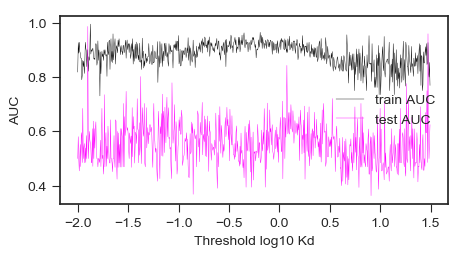

In [7]:
#from sklearn.model_selection import cross_val_score
import warnings; warnings.simplefilter('ignore')

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


thresholds = np.arange(-2.0,1.5,0.005)
train_AUC, test_AUC = [], []
for threshold in thresholds:
    y = np.where(df['LogKd'] >= threshold, 1, 0)
    
    X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=.25)
    
    clf = XGBClassifier(booster='gbtree', gamma=0, learning_rate=.1, 
                        max_delta_step=1, max_depth=3, min_child_weight=1, 
                        n_estimators=100, n_jobs=-1)
    
    #scores.append(cross_val_score(clf, X, y, cv=5, n_jobs=-1))
    clf.fit(X_train, y_train)
    train_AUC.append( roc_auc_score(y_train, clf.predict(X_train)) )
    test_AUC.append( roc_auc_score(y_test, clf.predict(X_test)) )

plt.figure(figsize=[5,2.5], dpi=100)
plt.plot(thresholds, train_AUC, color='black', lw=0.3, label='train AUC')
plt.plot(thresholds, test_AUC, color='magenta', lw=0.3, label='test AUC')

plt.legend(loc='lower middle')
#plt.ylim(0.5,1.05)
plt.xlabel('Threshold log10 Kd')
plt.ylabel('AUC');


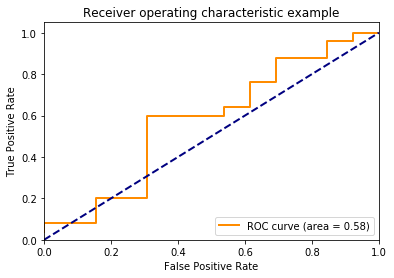

In [127]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier


#thresholds = np.arange(-2,1,1)
threshold = -1.0
y = np.where(df['LogKd'] >= threshold, 1, 0)

n_classes = y.shape[0]

clf = AdaBoostClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [128]:
# make predictions for test data
y_pred = clf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
y_pred_full = classifier.predict(X)
data = confusion_matrix(y, y_pred_full)
print('Confusion matrix')
print(data)
        

Accuracy: 60.53%
Confusion matrix
[[ 27  16]
 [  5 102]]
